<a href="https://colab.research.google.com/github/adamstra/Computer_Vision/blob/main/Devoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
def load_mat_files(folder, variable_name):
    data_list = []
    for filename in os.listdir(folder):
        if filename.endswith(".mat"):
            mat_file = sio.loadmat(os.path.join(folder, filename))
            data_list.append(mat_file[variable_name])
    return np.array(data_list)


# Charger les données d'entrée et les ground truths
input_folder = "/content/drive/MyDrive/Computer_Vision/enroule"
gt_folder = "/content/drive/MyDrive/Computer_Vision/deroule"

X_data = load_mat_files(input_folder, "input")
y_data = load_mat_files(gt_folder, "gt")

In [9]:
# Normalisation des données
X_data = X_data / np.max(X_data)
y_data = y_data / np.max(y_data)

# Vérification des formes
print(f"Forme des données input: {X_data.shape}")
print(f"Forme des données ground truth: {y_data.shape}")

Forme des données input: (2007, 128, 128)
Forme des données ground truth: (2000, 128, 128)


In [10]:
X_data = X_data[:y_data.shape[0]]

In [11]:
# Ajouter une dimension supplémentaire pour les canaux (1 pour les images en niveaux de gris)
X_data = np.expand_dims(X_data, axis=-1)
y_data = np.expand_dims(y_data, axis=-1)

# Ensuite, divisez les données comme avant
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

# Vérification des formes après ajout de la dimension des canaux
print(f"Forme des données d'entraînement après ajout des canaux: {X_train.shape}")
print(f"Forme des données de validation après ajout des canaux: {X_val.shape}")

Forme des données d'entraînement après ajout des canaux: (1400, 128, 128, 1)
Forme des données de validation après ajout des canaux: (600, 128, 128, 1)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [13]:
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Contraction path
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)

    # Expansive path
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c7)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [14]:
# Définir le modèle
input_shape = X_train.shape[1:]

# Supposons que vos données sont des images de forme (hauteur, largeur, canaux)
model = unet_model(input_shape)

# Compilation du modèle
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Affichage du résumé du modèle
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 128)    │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,696,193 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Entraînement du modèle
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

# Sauvegarder le modèle entraîné
model.save("/content/drive/MyDrive/Computer_Vision/unet_model.h5")

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 492ms/step - accuracy: 5.9079e-05 - loss: 0.6461 - val_accuracy: 6.1035e-05 - val_loss: 0.6377
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 169ms/step - accuracy: 6.1035e-05 - loss: 0.6381 - val_accuracy: 6.1035e-05 - val_loss: 0.6375
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 6.1035e-05 - loss: 0.6390 - val_accuracy: 6.1035e-05 - val_loss: 0.6381
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 6.1035e-05 - loss: 0.6392 - val_accuracy: 6.1035e-05 - val_loss: 0.6369
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 6.1035e-05 - loss: 0.6412 - val_accuracy: 6.1035e-05 - val_loss: 0.6371
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 6.1035e-05 - loss: 0.6376 - val_accuracy: 6.1035e-05 - val_loss: 0.6367
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 6.1035e-05 - loss: 0.6348 - val_accuracy: 6.1035e-05 - val_loss: 0.6382
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s

In [16]:
# Évaluer le modèle
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Loss sur validation: {val_loss}")
print(f"Accuracy sur validation: {val_accuracy}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 630ms/step - accuracy: 6.1035e-05 - loss: 0.6402
Loss sur validation: 0.6369093060493469
Accuracy sur validation: 6.103515625e-05


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


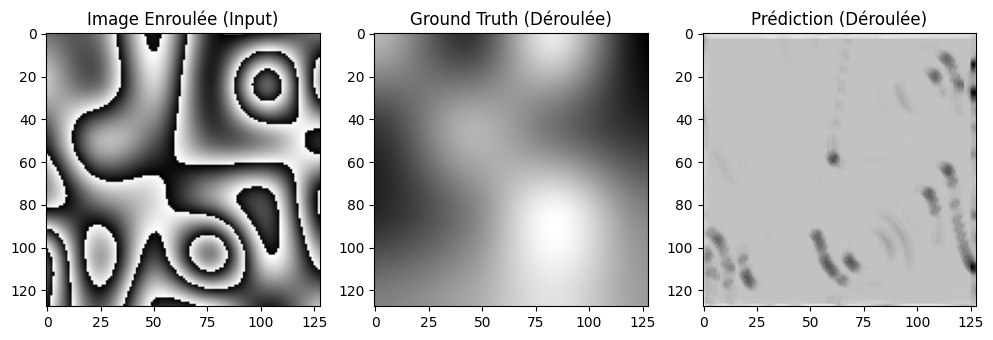

In [17]:
import matplotlib.pyplot as plt

# Faire des prédictions
y_pred = model.predict(X_val)

# Visualiser une image d'entrée, le ground truth et la prédiction
index = 0  # Changer l'indice pour visualiser d'autres images
plt.figure(figsize=(12, 4))

# Image d'entrée
plt.subplot(1, 3, 1)
plt.imshow(X_val[index].squeeze(), cmap='gray')
plt.title('Image Enroulée (Input)')

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(y_val[index].squeeze(), cmap='gray')
plt.title('Ground Truth (Déroulée)')

# Prédiction
plt.subplot(1, 3, 3)
plt.imshow(y_pred[index].squeeze(), cmap='gray')
plt.title('Prédiction (Déroulée)')

plt.show()


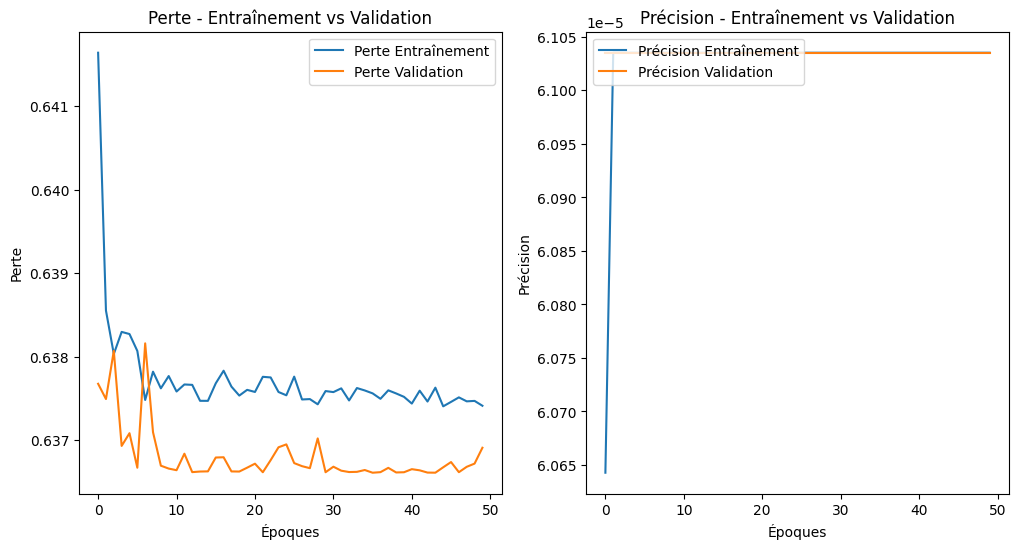

In [18]:
# Étape 1 : Extraire les données d'historique pour les graphiques
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

epochs_range = range(len(val_loss))

# Étape 2 : Tracer la perte (loss)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Perte Entraînement')
plt.plot(epochs_range, val_loss, label='Perte Validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend(loc='upper right')
plt.title('Perte - Entraînement vs Validation')

# Étape 3 : Tracer la précision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Précision Entraînement')
plt.plot(epochs_range, val_accuracy, label='Précision Validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend(loc='upper left')
plt.title('Précision - Entraînement vs Validation')

# Afficher les graphiques
plt.show()

# CNN


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

def simple_cnn_model(input_shape):
    model = models.Sequential()

    # Première couche convolutionnelle
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Deuxième couche convolutionnelle
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Troisième couche convolutionnelle
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Couche de flattening - This layer needs to be added back
    model.add(layers.Flatten())

    # Couche dense
    model.add(layers.Dense(128, activation='relu'))

    # Couche de sortie -  You could change this to a Dense layer
    # with 128*128 output units and reshape the output to match your target
    # Or you could use a combination of UpSampling2D and Conv2D layers
    # to get an output of the same shape
    model.add(layers.Dense(128*128, activation='sigmoid'))
    model.add(layers.Reshape((128, 128, 1)))

    return model

# Initialisation du modèle
input_shape = X_train.shape[1:]  # Forme des données d'entrée (ex : 128x128x1)
model1 = simple_cnn_model(input_shape)

# Compilation du modèle
model1.compile(optimizer='adam',
              loss='binary_crossentropy',  # Si c'est une tâche de segmentation binaire
              metrics=['accuracy'])

# Entraînement du modèle
history = model1.fit(X_train, y_train,
                    epochs=20,  # Ajustez le nombre d'époques
                    batch_size=32,
                    validation_data=(X_val, y_val))

# Évaluation du modèle
val_loss, val_accuracy = model1.evaluate(X_val, y_val, verbose=1)
print(f"Loss sur validation: {val_loss}")
print(f"Accuracy sur validation: {val_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 5.3409e-05 - loss: 0.6622 - val_accuracy: 6.1035e-05 - val_loss: 0.6374
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 6.1035e-05 - loss: 0.6391 - val_accuracy: 6.1035e-05 - val_loss: 0.6371
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 6.1035e-05 - loss: 0.6391 - val_accuracy: 6.1035e-05 - val_loss: 0.6385
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 6.1035e-05 - loss: 0.6377 - val_accuracy: 6.1035e-05 - val_loss: 0.6379
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 6.1035e-05 - loss: 0.6319 - val_accuracy: 6.1035e-05 - val_loss: 0.6390
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 6.1035e-05 - loss: 0.6304 - val_accuracy: 6.1035e-05 - val_loss: 0.6414
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 6.1035e-05 - loss: 0.6287 - val_accuracy: 6.1035e-05 - val_loss: 0.6439
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Text(0.5, 1.0, 'Prédiction (Déroulée)')

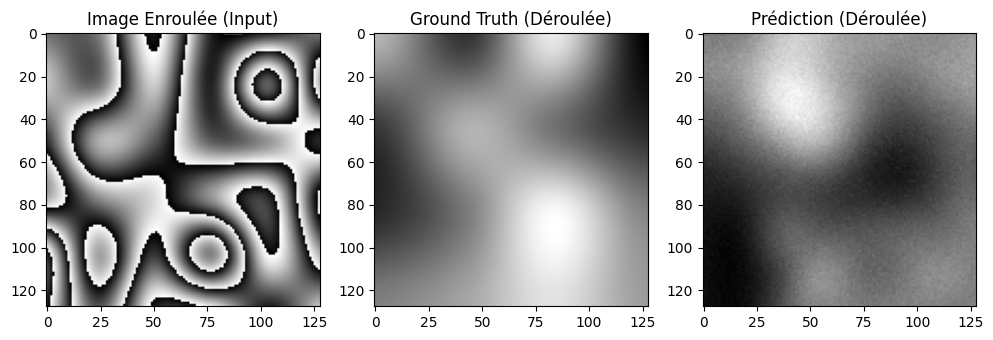

In [37]:
import matplotlib.pyplot as plt

# Faire des prédictions - use model1 instead of model
y_pred = model1.predict(X_val)

# Assurez-vous que vos prédictions ont bien la bonne forme
if len(y_pred.shape) == 3:
    y_pred = np.expand_dims(y_pred, axis=-1)
def reshape_for_plot(data):
    if data.shape[-1] == 1:
        return data.squeeze()
    else:
        return data

# Visualiser une image d'entrée, le ground truth et la prédiction
index = 0  # Changer l'indice pour visualiser d'autres images
plt.figure(figsize=(12, 4))

# Image d'entrée
plt.subplot(1, 3, 1)
plt.imshow(reshape_for_plot(X_val[index]), cmap='gray')
plt.title('Image Enroulée (Input)')

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(reshape_for_plot(y_val[index]), cmap='gray')
plt.title('Ground Truth (Déroulée)')

# Prédiction
plt.subplot(1, 3, 3)
plt.imshow(reshape_for_plot(y_pred[index]), cmap='gray')
plt.title('Prédiction (Déroulée)')

---
# ADAMA TRAORE
---